In [2]:
#league rules!
numberOfTeams = 10

isFlex = True

ppr = 1
rushYards = .1
receivingYards = .1
rushTD = 6
receivingTD = 6
passYards = 1/25
passTD = 4
fmb = -2
int = -2

In [1]:
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import norm
from joblib import dump

In [3]:
combo2 = pd.read_csv("../data/2023_model_data.csv")
modelData = combo2.drop(columns=["Name", "Unnamed: 0", "team.y", "position.y", "position.x", "team.x", "nextSeasonsTeam", "gsis_id", "team", "name rank", "gsis_id", "team.y", "position.y"])

In [4]:
#label encoding
label_encoders = {}
for column in modelData.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    modelData[column] = le.fit_transform(modelData[column])
    label_encoders[column] = le

In [5]:
season = 2023
train = modelData[modelData["year"] < season]
test = modelData[modelData["year"] == season]
c2_whole = combo2[combo2["year"] == season]
names = c2_whole['Name'].reset_index(drop=True)
positions = c2_whole['position'].reset_index(drop=True)

In [6]:
#data
train_y = train["nextSeasonPAR"]
train_x = train.drop(columns = "nextSeasonPAR", axis = 1)
test_y = test["nextSeasonPAR"]
test_x = test.drop(columns = "nextSeasonPAR", axis = 1)

In [53]:
#train it
ntrees = 500
rf = RandomForestRegressor(n_estimators=ntrees)
rf.fit(train_x, train_y)

RandomForestRegressor(n_estimators=500)

In [103]:
#FOR SAVING MODEL FOR CALIBRATION
# dump(rf, f"models/{season}_rf_{ntrees}tree.joblib")
# test_x.to_csv(f"data/test_x_{season}.csv", index=False)
# test_y.to_csv(f"data/test_y_{season}.csv", index=False)
# c2_whole.to_csv(f"data/c2_whole_{season}.csv", index=False)

In [54]:
#residuals plot
preds = rf.predict(test_x)

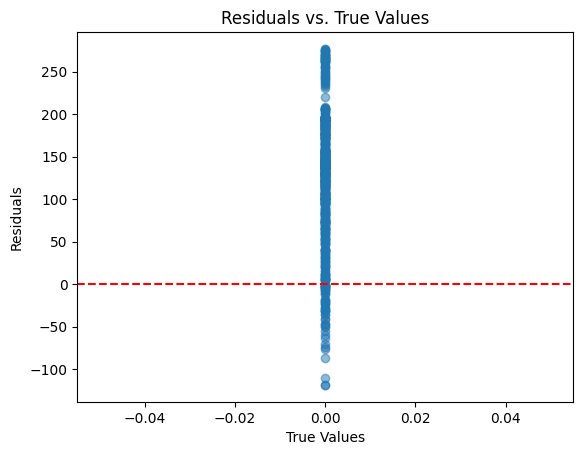

In [55]:
residuals = test_y - preds

# Plot residuals
plt.scatter(test_y, residuals, alpha=0.5)
plt.title('Residuals vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y, preds)
mse = mean_squared_error(test_y, preds)
r2 = r2_score(test_y, rf.predict(test_x))

print(f"MAE: {mae}, MSE: {mse}, R^2: {r2}")

MAE: 129.92236765957438, MSE: 21182.927753820048, R^2: 0.0


In [57]:
#prediction distributions
# Get predictions from each tree in the RandomForestRegressor
tree_predictions = []

for tree in rf.estimators_:
    tree_predictions.append(tree.predict(test_x))

# Convert the predictions to a DataFrame
tree_predictions_df = pd.DataFrame(tree_predictions).transpose()
tree_predictions_df.columns = [f"Tree_{i+1}" for i in range(rf.n_estimators)]

# Display the first few rows of the tree predictions DataFrame
tree_predictions_df.head()

/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X 

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_491,Tree_492,Tree_493,Tree_494,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500
0,-91.54,-91.54,-149.04,-150.00,32.52,-91.54,125.72,185.32,-114.10,41.20,...,-91.54,-3.90,109.40,-118.60,125.72,-21.86,-113.30,0.00,47.60,21.3
1,57.22,53.02,-161.08,-43.64,125.72,144.18,62.98,47.00,144.18,0.00,...,84.70,57.22,144.18,78.70,-14.50,125.72,171.26,-62.80,18.70,13.0
2,42.10,197.74,-25.34,-164.34,125.50,26.30,-24.30,45.46,144.18,138.22,...,176.94,138.22,144.18,81.42,19.06,-164.34,57.22,-62.80,-21.28,0.0
3,295.20,212.10,50.30,64.10,113.10,220.40,199.20,-161.90,-0.20,212.10,...,62.80,64.44,5.50,109.40,220.20,215.70,64.10,186.22,59.80,111.5
4,-164.34,53.02,-157.66,-43.64,95.36,-164.34,-141.98,19.06,144.18,171.26,...,-6.50,57.04,-74.40,93.00,125.34,32.52,197.74,-21.86,18.70,13.0


In [58]:
#include more details in pred dataframe
tree_predictions_df['name'] = names
tree_predictions_df['preds'] = preds
tree_predictions_df['pos'] = positions

tree_predictions_df

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_494,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500,name,preds,pos
0,-91.54,-91.54,-149.04,-150.00,32.52,-91.54,125.72,185.32,-114.10,41.20,...,-118.60,125.72,-21.86,-113.30,0.00,47.60,21.3,PatrickMahomes,31.32464,QB
1,57.22,53.02,-161.08,-43.64,125.72,144.18,62.98,47.00,144.18,0.00,...,78.70,-14.50,125.72,171.26,-62.80,18.70,13.0,JalenHurts,41.07132,QB
2,42.10,197.74,-25.34,-164.34,125.50,26.30,-24.30,45.46,144.18,138.22,...,81.42,19.06,-164.34,57.22,-62.80,-21.28,0.0,JoshAllen,27.71596,QB
3,295.20,212.10,50.30,64.10,113.10,220.40,199.20,-161.90,-0.20,212.10,...,109.40,220.20,215.70,64.10,186.22,59.80,111.5,ChristianMcCaffrey,70.46828,RB
4,-164.34,53.02,-157.66,-43.64,95.36,-164.34,-141.98,19.06,144.18,171.26,...,93.00,125.34,32.52,197.74,-21.86,18.70,13.0,JoeBurrow,35.47188,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-168.30,-168.30,-168.30,-168.30,-165.40,-165.40,-170.50,-165.40,-138.10,-146.60,...,-168.30,-143.70,-152.10,-166.60,-168.30,-149.30,-165.4,JakeTonges,-157.16880,TE
607,-193.50,-202.40,-202.40,-202.40,-124.26,-202.40,-202.40,-216.42,-202.40,-202.40,...,-200.20,-124.26,-202.40,-221.36,-202.40,-202.40,-199.3,JoshAli,-182.54932,WR
608,-257.60,-264.72,-284.86,-287.74,-281.32,-275.90,-276.50,-272.78,-264.04,-265.24,...,-266.64,-275.90,-253.48,-275.70,-276.50,-284.86,-279.7,NateSudfeld,-265.56676,QB
609,-275.90,-276.10,-275.90,-274.08,-301.70,-273.08,-275.90,-257.60,-272.02,-284.54,...,-275.90,-276.54,-272.78,-275.90,-262.00,-284.86,-279.7,CJBeathard,-270.43700,QB


In [59]:
#add posrank
# Group by position, sort by RF_Prediction in descending order, then assign a rank within each group
tree_predictions_df['posrank'] = np.int64(tree_predictions_df.groupby('pos')['preds'].rank(ascending=False, method='min'))

# Sort the DataFrame based on position and then by Positional_Rank
tree_predictions_df = tree_predictions_df.sort_values(by=['pos', 'posrank'])

tree_predictions_df

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500,name,preds,pos,posrank
1,57.22,53.02,-161.08,-43.64,125.72,144.18,62.98,47.00,144.18,0.00,...,-14.50,125.72,171.26,-62.80,18.70,13.00,JalenHurts,41.07132,QB,1
4,-164.34,53.02,-157.66,-43.64,95.36,-164.34,-141.98,19.06,144.18,171.26,...,125.34,32.52,197.74,-21.86,18.70,13.00,JoeBurrow,35.47188,QB,2
0,-91.54,-91.54,-149.04,-150.00,32.52,-91.54,125.72,185.32,-114.10,41.20,...,125.72,-21.86,-113.30,0.00,47.60,21.30,PatrickMahomes,31.32464,QB,3
2,42.10,197.74,-25.34,-164.34,125.50,26.30,-24.30,45.46,144.18,138.22,...,19.06,-164.34,57.22,-62.80,-21.28,0.00,JoshAllen,27.71596,QB,4
28,61.26,-57.58,172.92,0.00,-8.90,-70.50,-57.26,0.00,-0.94,61.26,...,-166.46,-57.26,13.00,155.66,60.46,125.34,JustinFields,19.62724,QB,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,-216.42,-216.42,-202.40,-220.14,-216.42,-202.40,-216.42,-220.14,-202.40,-216.42,...,-194.30,-216.42,-220.14,-202.40,-216.42,-216.42,JaydenReed,-205.60792,WR,232
576,-216.42,-216.42,-202.40,-220.14,-216.42,-202.40,-216.42,-220.14,-202.40,-216.42,...,-209.64,-216.42,-220.14,-202.40,-216.42,-216.42,JonathanMingo,-206.02684,WR,233
568,-216.42,-216.42,-200.20,-209.64,-216.42,-202.40,-216.42,-220.14,-202.40,-216.42,...,-209.64,-216.42,-220.14,-202.40,-216.42,-216.42,GabrielDavis,-206.26472,WR,234
579,-216.42,-216.42,-202.40,-220.14,-220.14,-202.40,-216.42,-220.14,-202.40,-216.42,...,-194.30,-220.14,-220.14,-202.40,-216.42,-216.42,RasheeRice,-207.13840,WR,235


In [60]:
#make the "individuals" df
individuals = tree_predictions_df.copy()
tree_predictions_df[tree_predictions_df['posrank'] <= 3]

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_495,Tree_496,Tree_497,Tree_498,Tree_499,Tree_500,name,preds,pos,posrank
1,57.22,53.02,-161.08,-43.64,125.72,144.18,62.98,47.00,144.18,0.00,...,-14.50,125.72,171.26,-62.80,18.70,13.00,JalenHurts,41.07132,QB,1
4,-164.34,53.02,-157.66,-43.64,95.36,-164.34,-141.98,19.06,144.18,171.26,...,125.34,32.52,197.74,-21.86,18.70,13.00,JoeBurrow,35.47188,QB,2
0,-91.54,-91.54,-149.04,-150.00,32.52,-91.54,125.72,185.32,-114.10,41.20,...,125.72,-21.86,-113.30,0.00,47.60,21.30,PatrickMahomes,31.32464,QB,3
6,62.80,164.00,242.70,-74.10,125.00,260.30,208.60,-74.10,203.30,220.20,...,182.20,10.60,227.80,-114.10,62.80,220.20,AustinEkeler,118.69572,RB,1
19,220.40,137.36,171.20,125.00,-44.40,125.00,62.40,171.20,126.10,112.40,...,182.20,199.20,-11.90,47.00,-150.90,-8.24,DerrickHenry,87.08080,RB,2
3,295.20,212.10,50.30,64.10,113.10,220.40,199.20,-161.90,-0.20,212.10,...,220.20,215.70,64.10,186.22,59.80,111.50,ChristianMcCaffrey,70.46828,RB,3
5,-161.90,13.44,-162.00,27.70,38.80,208.10,-119.16,-119.16,-148.80,241.40,...,170.18,38.80,220.20,-23.30,158.00,186.34,TravisKelce,59.93852,TE,1
86,25.60,125.30,-13.40,-43.34,-159.80,-91.20,83.50,-149.20,-17.40,-33.70,...,5.60,-140.66,45.06,-213.34,124.70,237.10,DallasGoedert,22.12860,TE,2
33,34.10,23.40,81.80,-102.40,94.96,81.80,-34.80,-70.20,-199.10,20.40,...,33.74,-149.04,37.10,22.60,-194.30,70.00,TJHockenson,19.26128,TE,3
9,151.40,110.10,13.00,136.70,113.10,131.20,131.20,91.60,9.00,188.70,...,158.00,152.86,175.08,-54.10,134.80,164.00,CeeDeeLamb,118.31784,WR,1


In [61]:
#make a pred copy df
preds_copy = test_x.reset_index(drop=True).copy()
preds_copy['name'] = names
preds_copy['pos'] = positions
preds_copy['preds'] = preds
preds_copy['adp'] = preds_copy['rank'] * 1.2
preds_copy['adp_sd'] = preds_copy['rank'] * .5 + 1


preds_copy = preds_copy[['name', 'pos', 'rank', 'PAR', 'preds', 'adp', 'adp_sd']]

preds_copy.sort_values(by = 'rank')

,name,pos,rank,PAR,preds,adp,adp_sd
7,JustinJefferson,WR,1,175.08,110.67784,1.2,1.5
6,AustinEkeler,RB,2,217.30,118.69572,2.4,2.0
20,JaMarrChase,WR,3,99.94,74.16908,3.6,2.5
3,ChristianMcCaffrey,RB,4,251.56,70.46828,4.8,3.0
5,TravisKelce,TE,5,241.40,59.93852,6.0,3.5
...,...,...,...,...,...,...,...
333,ZachGentry,TE,300,-117.10,-142.89460,360.0,151.0
332,DyamiBrown,WR,300,-169.60,-153.14716,360.0,151.0
331,BrevinJordan,TE,300,-116.50,-130.75420,360.0,151.0
329,JalenNailor,WR,300,-169.50,-175.38004,360.0,151.0


In [62]:
individuals.to_csv("data/individuals.csv", index=False) 
preds_copy.to_csv("data/preds_copy.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'data'

In [63]:
#get replacement level player by position
import pandas as pd

# Filtering data based on conditions
replacement_rb = individuals[(individuals['pos'] == 'RB') & (individuals['posrank'] == 26)].iloc[:, :ntrees]
replacement_wr = individuals[(individuals['pos'] == 'WR') & (individuals['posrank'] == 26)].iloc[:, :ntrees]
replacement_te = individuals[(individuals['pos'] == 'TE') & (individuals['posrank'] == 11)].iloc[:, :ntrees]
replacement_qb = individuals[(individuals['pos'] == 'QB') & (individuals['posrank'] == 11)].iloc[:, :ntrees]

In [64]:
#roundup function
def roundUp(x, to=numberOfTeams):
    return to * (x // to + (x % to > 0))

In [75]:
def draft_optimize(individuals = individuals, yourTeam = yourTeam, draftedOverall = draftedOverall, preds_copy = preds_copy):
    # Assuming necessary data is already loaded: individuals, preds_copy, draftedOverall, yourTeam, etc.
    # ... [Your data loading code here]

    # Initialize DataFrames and lists
    createdDataframe = pd.DataFrame()
    secondDataframe = pd.DataFrame()
    created_rows = []

    yourDraft = individuals[individuals['name'].isin(yourTeam)]
    yourDraft['teamrank'] = np.int64(yourDraft.groupby('pos')['preds'].rank(ascending=False, method='min'))

    first_rb = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'RB')]
    second_rb = yourDraft[(yourDraft['teamrank'] == 2) & (yourDraft['pos'] == 'RB')]
    third_rb = yourDraft[(yourDraft['teamrank'] == 3) & (yourDraft['pos'] == 'RB')]
    first_wr = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'WR')]
    second_wr = yourDraft[(yourDraft['teamrank'] == 2) & (yourDraft['pos'] == 'WR')]
    third_wr = yourDraft[(yourDraft['teamrank'] == 3) & (yourDraft['pos'] == 'WR')]
    first_te = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'TE')]
    first_qb = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'QB')]

    first_flex = third_rb if third_rb.preds.max() > third_wr.preds.max() else third_wr

    # For RBs
    t_rb = replacement_rb.transpose()
    rbs = pd.concat([t_rb.sample(frac=1).transpose() for _ in range(3)], axis=0)
    if not first_rb.empty:
        rbs.iloc[0, :] = first_rb.iloc[0, :ntrees]
    if not second_rb.empty:
        rbs.iloc[1, :] = second_rb.iloc[0, :ntrees]
    if not first_flex.empty:
        rbs.iloc[2, :] = first_flex.iloc[0, :ntrees]

    # For WRs
    t_wr = replacement_wr.transpose()
    wrs = pd.concat([t_wr.sample(frac=1).transpose() for _ in range(3)], axis=0)
    if not first_wr.empty:
        wrs.iloc[0, :] = first_wr.iloc[0, :ntrees]
    if not second_wr.empty:
        wrs.iloc[1, :] = second_wr.iloc[0, :ntrees]
    if not first_flex.empty:
        wrs.iloc[2, :] = first_flex.iloc[0, :ntrees]

    # For TEs
    tes = replacement_te.copy()  # Create a copy to prevent modification of original dataframe
    if not first_te.empty:
        tes.iloc[0, :] = first_te.iloc[0, :ntrees]

    # For QBs
    qbs = replacement_qb.copy()  # Create a copy to prevent modification of original dataframe
    if not first_qb.empty:
        qbs.iloc[0, :] = first_qb.iloc[0, :ntrees]

    # Dictionary for positions
    pos_dict = {
        'RB': rbs,
        'WR': wrs,
        'TE': tes,
        'QB': qbs
    }

    # Filter out players in draftedOverall from copy
    available = preds_copy[~preds_copy['name'].isin(draftedOverall)]
    available = available.sort_values(by=['pos', 'preds'], ascending=False).groupby('pos').head(100).reset_index(drop=True)

    for j in range(len(available)):
        player = available.iloc[j]
        name = player['name']
        position = player['pos']

        # Use dictionary to get positional_df
        positional_df = pos_dict[position]

        indi_preds = individuals[(individuals['name'] == name) & (individuals['pos'] == position)].iloc[:, :ntrees].iloc[0]
        total_pt_gains = 0
        pct_better = 0

        for i in range(len(positional_df)):
            row = positional_df.iloc[i]
            better = indi_preds.values > row[::-1].values  # Using values to get numpy arrays
            pct_better = max(pct_better, sum(better) / ntrees)
            avg_pts_gains = np.mean(indi_preds[better].values - np.array(row[::-1])[better])
            total_pt_gains = max(total_pt_gains, pct_better * avg_pts_gains)

        # Finding pick number, your next pick, and the likelihood of a player staying on board
        pickNumber = len(draftedOverall) + 1
        ceiling = roundUp(pickNumber, numberOfTeams)
        leftTillEndOfRound = ceiling - pickNumber
        nextPick = ceiling + leftTillEndOfRound + 1

        # Calculating the chance of staying on board
        chanceOfStayingOnBoard = round(1 - norm.cdf(nextPick, player['adp'], player['adp_sd']), 2)

        # For the round after the likelihood
        ceiling = roundUp(nextPick, numberOfTeams)
        leftTillEndOfRound = ceiling - nextPick
        pickAfter = ceiling + leftTillEndOfRound + 1

        chanceOfStayingOnBoardTwoRounds = 1 - norm.cdf(pickAfter, player['adp'], player['adp_sd'])

        # For the round after...
        ceiling = roundUp(pickAfter, numberOfTeams)
        leftTillEndOfRound = ceiling - pickAfter
        pickEvenAfter = ceiling + leftTillEndOfRound + 1

        chanceOfStayingOnThreeRounds = 1 - norm.cdf(pickEvenAfter, player['adp'], player['adp_sd'])

        # Creating a dictionary to represent the new row
        created_row = {
            'name': player['name'],
            'pos': position,
            'preds': player['preds'],
            'pct_better': pct_better,
            'ADP': player['adp'],
            'total_pt_gains': total_pt_gains,
            'chanceOfStayingOnBoard': chanceOfStayingOnBoard,
            'chanceOfStayingOnBoardTwoRounds': chanceOfStayingOnBoardTwoRounds,
            'chanceOfStayingOnThreeRounds': chanceOfStayingOnThreeRounds
        }
        created_rows.append(created_row)

    # Convert the created rows to a DataFrame
    createdDataframe = pd.DataFrame(created_rows)

    # Process for the second dataframe
    second_rows = []

    for _, newRow in createdDataframe.iterrows():
        playerPosition = newRow['pos']

        # Filter and sort
        positionallyFiltered = createdDataframe[createdDataframe['pos'] == playerPosition]
        positionallyFiltered = positionallyFiltered.sort_values(by='total_pt_gains', ascending=False).head(12).copy()

        # Initialize new columns
        positionallyFiltered['chance_of_best_option'] = 0
        positionallyFiltered['chance_of_best_option_2'] = 0
        positionallyFiltered['chance_of_best_option_3'] = 0

        for j, row in positionallyFiltered.iterrows():
            better_players = positionallyFiltered[positionallyFiltered['total_pt_gains'] > row['total_pt_gains']]

            # Calculating probabilities for best option next round
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnBoard'])
            p_avail = row['chanceOfStayingOnBoard']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option'] = p_best_option

            # ... for two rounds later
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnBoardTwoRounds'])
            p_avail = row['chanceOfStayingOnBoardTwoRounds']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option_2'] = p_best_option

            # ... and for three rounds later
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnThreeRounds'])
            p_avail = row['chanceOfStayingOnThreeRounds']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option_3'] = p_best_option

        # Calculating average positional values
        nextRoundValue = np.sum(positionallyFiltered['chance_of_best_option'] * positionallyFiltered['total_pt_gains'])
        nextRoundValue = 1000 if np.isinf(nextRoundValue) or np.isnan(nextRoundValue) else nextRoundValue
        newRow['valueOverNextRound'] = newRow['total_pt_gains'] - nextRoundValue

        valueOverTwoRounds = np.sum(positionallyFiltered['chance_of_best_option_2'] * positionallyFiltered['total_pt_gains'])
        valueOverTwoRounds = 1000 if np.isinf(valueOverTwoRounds) or np.isnan(valueOverTwoRounds) else valueOverTwoRounds
        newRow['valueOverTwoRounds'] = newRow['total_pt_gains'] - valueOverTwoRounds

        valueOverThreeRounds = np.sum(positionallyFiltered['chance_of_best_option_3'] * positionallyFiltered['total_pt_gains'])
        valueOverThreeRounds = 1000 if np.isinf(valueOverThreeRounds) or np.isnan(valueOverThreeRounds) else valueOverThreeRounds
        newRow['valueOverThreeRounds'] = newRow['total_pt_gains'] - valueOverThreeRounds

        second_rows.append(newRow)

    secondDataframe = pd.DataFrame(second_rows)

    print(nextPick)
    return secondDataframe

In [76]:
#your team
draftedOverall = []

yourTeam = []

In [78]:
secondDataframe = draft_optimize(draftedOverall=draftedOverall, yourTeam=yourTeam)

desired_columns = ['name', 'pos', 'valueOverNextRound', 'ADP', 'chanceOfStayingOnBoard', 'preds']
secondDataframe = pd.concat([secondDataframe[desired_columns], secondDataframe.drop(desired_columns, axis=1)], axis=1)

secondDataframe.sort_values(by = 'valueOverNextRound', ascending = False)

20


,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds
200,AustinEkeler,RB,59.510245,2.4,0.00,118.69572,0.826,159.09124,0.000000,0.000000,61.280698,84.083423
100,TravisKelce,TE,41.532838,6.0,0.00,59.93852,0.722,117.24916,0.000009,0.000000,41.541051,41.920777
0,CeeDeeLamb,WR,28.909075,16.8,0.34,118.31784,0.906,138.34336,0.299792,0.001866,31.762097,80.792795
201,DerrickHenry,RB,28.441965,12.0,0.09,87.08080,0.786,128.02296,0.066807,0.000002,30.212418,53.015143
1,JustinJefferson,WR,26.464395,1.2,0.00,110.67784,0.850,135.89868,0.000000,0.000000,29.317417,78.348115
...,...,...,...,...,...,...,...,...,...,...,...,...
96,QuezWatkins,WR,-103.888605,360.0,0.99,-145.27280,0.086,5.54568,0.987617,0.982963,-101.035583,-52.004885
89,LaviskaShenault,WR,-104.766725,360.0,0.99,-136.23492,0.104,4.66756,0.987617,0.982963,-101.913703,-52.883005
99,DeAndreCarter,WR,-105.039445,360.0,0.99,-148.20680,0.084,4.39484,0.987617,0.982963,-102.186423,-53.155725
95,ChrisMoore,WR,-105.165165,360.0,0.99,-144.16392,0.074,4.26912,0.987617,0.982963,-102.312143,-53.281445


In [81]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(secondDataframe.sort_values(by = 'total_pt_gains', ascending = False))

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds
200,AustinEkeler,RB,59.510245,2.4,0.00,118.69572,0.826,159.09124,0.000000e+00,0.000000e+00,61.280698,84.083423
0,CeeDeeLamb,WR,28.909075,16.8,0.34,118.31784,0.906,138.34336,2.997916e-01,1.865813e-03,31.762097,80.792795
1,JustinJefferson,WR,26.464395,1.2,0.00,110.67784,0.850,135.89868,0.000000e+00,0.000000e+00,29.317417,78.348115
201,DerrickHenry,RB,28.441965,12.0,0.09,87.08080,0.786,128.02296,6.680720e-02,1.530627e-06,30.212418,53.015143
202,ChristianMcCaffrey,RB,25.363965,4.8,0.00,70.46828,0.708,124.94496,3.332045e-08,0.000000e+00,27.134418,49.937143
100,TravisKelce,TE,41.532838,6.0,0.00,59.93852,0.722,117.24916,9.107649e-06,0.000000e+00,41.541051,41.920777
203,JonathanTaylor,RB,10.839045,14.4,0.21,63.75876,0.730,110.42004,1.728770e-01,1.275211e-04,12.609498,35.412223
3,JaMarrChase,WR,-1.819485,3.6,0.00,74.16908,0.772,107.61480,1.701417e-12,0.000000e+00,1.033537,50.064235
2,AJBrown,WR,-4.309965,20.4,0.52,75.94692,0.792,105.12432,4.748204e-01,1.954881e-02,-1.456943,47.573755
205,SaquonBarkley,RB,0.546605,10.8,0.05,49.60676,0.712,100.12760,3.183058e-02,5.508669e-08,2.317058,25.119783


In [70]:
auction_copy = secondDataframe.copy()

auction_copy['pred_posrank'] = np.int64(secondDataframe.groupby('pos')['total_pt_gains'].rank(ascending=False, method='min'))


auction_copy.sort_values(by = 'valueOverNextRound', ascending = False)

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds,pred_posrank
60,AustinEkeler,RB,57.766977,2.4,0.00,118.69572,0.832,157.83360,0.000000,0.000000,59.451227,82.003155,1
30,TravisKelce,TE,41.532838,6.0,0.00,59.93852,0.722,117.24916,0.000009,0.000000,41.541051,41.920777,1
61,DerrickHenry,RB,30.048537,12.0,0.09,87.08080,0.772,130.11516,0.066807,0.000002,31.732787,54.284715,2
1,JustinJefferson,WR,29.002948,1.2,0.00,110.67784,0.864,137.02712,0.000000,0.000000,31.810266,80.264787,1
0,CeeDeeLamb,WR,27.840348,16.8,0.34,118.31784,0.900,135.86452,0.299792,0.001866,30.647666,79.102187,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,RyanTannehill,QB,-79.185180,291.6,0.99,-146.14996,0.200,16.58136,0.986412,0.980006,-79.079062,-73.671480,26
119,TomBrady,QB,-80.111140,360.0,0.99,-172.99028,0.176,15.65540,0.987617,0.982963,-80.005022,-74.597440,27
115,BrockPurdy,QB,-80.571380,319.2,0.99,-143.90980,0.176,15.19516,0.986972,0.981401,-80.465262,-75.057680,28
118,BryceYoung,QB,-83.744020,292.8,0.99,-165.90672,0.166,12.02252,0.986439,0.980074,-83.637902,-78.230320,29


In [71]:
filtered = auction_copy.query(
    "(pos == 'RB' and pred_posrank <= 26) or "
    "(pos == 'WR' and pred_posrank <= 26) or "
    "(pos == 'TE' and pred_posrank <= 11) or "
    "(pos == 'QB' and pred_posrank <= 11)"
)

filtered['adjusted_total_pt_gains'] = filtered['total_pt_gains'] - filtered.groupby('pos')['total_pt_gains'].transform('min')

total_points_to_be_acquired = sum(filtered['adjusted_total_pt_gains'])

/var/folders/vx/026hlx851_zcnp0g16d50p2r0000gn/T/ipykernel_27253/2548776855.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['adjusted_total_pt_gains'] = filtered['total_pt_gains'] - filtered.groupby('pos')['total_pt_gains'].transform('min')


In [72]:
filtered['pct_of_all_acquirable_points'] = filtered['adjusted_total_pt_gains'] /  total_points_to_be_acquired
budget = 198
available_spots = 10

# Compute the average adjusted_total_pt_gains for each position
position_avg = filtered.groupby('pos')['adjusted_total_pt_gains'].transform('mean')

# Create the multiplier column
filtered['multiplier'] = filtered['adjusted_total_pt_gains'] / position_avg

filtered['auction_value'] = (budget/available_spots) * filtered['multiplier']

filtered

/var/folders/vx/026hlx851_zcnp0g16d50p2r0000gn/T/ipykernel_27253/4149552763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['pct_of_all_acquirable_points'] = filtered['adjusted_total_pt_gains'] /  total_points_to_be_acquired
/var/folders/vx/026hlx851_zcnp0g16d50p2r0000gn/T/ipykernel_27253/4149552763.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['multiplier'] = filtered['adjusted_total_pt_gains'] / position_avg
/var/folders/vx/026hlx851_zcnp0g16d50p2r0000gn/T/ipykernel_27253/41495

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds,pred_posrank,adjusted_total_pt_gains,pct_of_all_acquirable_points,multiplier,auction_value
0,CeeDeeLamb,WR,27.840348,16.8,0.34,118.31784,0.900,135.86452,2.997916e-01,0.001866,30.647666,79.102187,2,92.70504,0.047595,2.996359,59.327915
1,JustinJefferson,WR,29.002948,1.2,0.00,110.67784,0.864,137.02712,0.000000e+00,0.000000,31.810266,80.264787,1,93.86764,0.048191,3.033936,60.071938
2,AJBrown,WR,-4.268372,20.4,0.52,75.94692,0.802,103.75580,4.748204e-01,0.019549,-1.461054,46.993467,4,60.59632,0.031110,1.958560,38.779481
3,JaMarrChase,WR,-1.779372,3.6,0.00,74.16908,0.766,106.24480,1.701417e-12,0.000000,1.027946,49.482467,3,63.08532,0.032388,2.039008,40.372352
4,DavanteAdams,WR,-12.026972,13.2,0.15,55.74196,0.744,95.99720,1.150697e-01,0.000019,-9.219654,39.234867,5,52.83772,0.027127,1.707791,33.814254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,TrevorLawrence,QB,-27.959460,90.0,0.97,-4.37644,0.590,67.80708,9.634502e-01,0.902977,-27.853342,-22.445760,7,10.09256,0.005181,0.535906,10.610933
97,LamarJackson,QB,-31.322420,49.2,0.91,-6.14364,0.556,64.44412,9.051771e-01,0.665641,-31.216302,-25.808720,8,6.72960,0.003455,0.357336,7.075245
98,DeshaunWatson,QB,-31.384060,88.8,0.96,-11.18160,0.548,64.38248,9.628053e-01,0.900466,-31.277942,-25.870360,9,6.66796,0.003423,0.354063,7.010439
99,DakPrescott,QB,-32.921420,109.2,0.97,-16.78952,0.526,62.84512,9.710711e-01,0.931647,-32.815302,-27.407720,10,5.13060,0.002634,0.272430,5.394117


In [73]:
secondDataframe['auction_value'] = filtered['auction_value']
secondDataframe['auction_value'].fillna(0, inplace=True)
secondDataframe.sort_values(by = 'auction_value', ascending = False).head(200)

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds,auction_value
60,AustinEkeler,RB,57.766977,2.4,0.00,118.69572,0.832,157.83360,0.000000,0.000000,59.451227,82.003155,80.513671
30,TravisKelce,TE,41.532838,6.0,0.00,59.93852,0.722,117.24916,0.000009,0.000000,41.541051,41.920777,69.308965
1,JustinJefferson,WR,29.002948,1.2,0.00,110.67784,0.864,137.02712,0.000000,0.000000,31.810266,80.264787,60.071938
61,DerrickHenry,RB,30.048537,12.0,0.09,87.08080,0.772,130.11516,0.066807,0.000002,31.732787,54.284715,59.635034
0,CeeDeeLamb,WR,27.840348,16.8,0.34,118.31784,0.900,135.86452,0.299792,0.001866,30.647666,79.102187,59.327915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,DAndreSwift,RB,-50.781943,112.8,0.97,-22.67232,0.498,49.28468,0.972094,0.935325,-49.097693,-26.545765,0.000000
87,AJDillon,RB,-56.396263,114.0,0.97,-25.89208,0.472,43.67036,0.972414,0.936467,-54.712013,-32.160085,0.000000
58,LoganThomas,TE,-62.617402,295.2,0.99,-83.50092,0.246,13.09892,0.986492,0.980208,-62.609189,-62.229463,0.000000
89,RaheemMostert,RB,-59.071943,144.0,0.98,-34.90072,0.450,40.99468,0.978121,0.955895,-57.387693,-34.835765,0.000000


In [74]:
secondDataframe.to_csv('auction_value.csv')

In [48]:
secondDataframe

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds,auction_value
0,CeeDeeLamb,WR,34.641706,16.8,0.34,114.9520,0.86,143.6180,2.997916e-01,1.865813e-03,37.546705,85.031367,48.768354
1,JustinJefferson,WR,27.924106,1.2,0.00,108.2154,0.86,136.9004,0.000000e+00,0.000000e+00,30.829105,78.313767,45.292757
2,CooperKupp,WR,-1.912694,7.2,0.00,74.2308,0.80,107.0636,2.802933e-04,1.110223e-16,0.992305,48.476967,29.855593
3,JaMarrChase,WR,-9.566094,3.6,0.00,60.7610,0.71,99.4102,1.701417e-12,0.000000e+00,-6.661095,40.823567,25.895825
4,DavanteAdams,WR,-9.631094,13.2,0.15,55.9040,0.72,99.3452,1.150697e-01,1.869224e-05,-6.726095,40.758567,25.862195
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,BrockPurdy,QB,-95.490261,319.2,0.99,-151.7608,0.18,17.2460,9.869719e-01,9.814009e-01,-94.832473,-79.221672,NaN
116,RyanTannehill,QB,-96.081461,291.6,0.99,-153.0322,0.15,16.6548,9.864120e-01,9.800062e-01,-95.423673,-79.812872,NaN
117,MacJones,QB,-104.304661,321.6,0.99,-160.0446,0.11,8.4316,9.870152e-01,9.815073e-01,-103.646873,-88.036072,NaN
118,BryceYoung,QB,-97.441461,292.8,0.99,-162.3988,0.20,15.2948,9.864390e-01,9.800742e-01,-96.783673,-81.172872,NaN


In [131]:
print(yourDraft['preds'].isnull().sum())


0


In [132]:
print(pd.__version__)


2.0.3


In [137]:
yourDraft.groupby('pos')['preds'].rank(ascending=False, method='min').apply(lambda x: np.int64(x).item())

9    1
Name: preds, dtype: int64

In [138]:
yourDraft

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos,posrank,ranked_preds
9,41.2,120.0,67.1,125.0,58.8,-141.2,62.8,7.6,295.2,62.8,...,106.06,251.7,137.5,24.0,150.8,JonathanTaylor,73.8214,RB,4,1


In [88]:
#soslow
condition = (
    (secondDataframe['name'] == 'JoeBurrow') |
    (secondDataframe['name'] == 'AustinEkeler') |
    (secondDataframe['name'] == 'DerrickHenry') |
    (secondDataframe['name'] == 'ChristianKirk') |
    (secondDataframe['name'] == 'BrandonAiyuk') |
    (secondDataframe['name'] == 'TJHockenson') |
    (secondDataframe['name'] == 'DalvinCook')
)

sum(secondDataframe[condition]['total_pt_gains'])

636.0510800000001

In [89]:
#fleet
condition = (
    (secondDataframe['name'] == 'JustinHerbert') |
    (secondDataframe['name'] == 'RachaadWhite') |
    (secondDataframe['name'] == 'JamesConner') |
    (secondDataframe['name'] == 'JustinJefferson') |
    (secondDataframe['name'] == 'CooperKupp') |
    (secondDataframe['name'] == 'DarrenWaller') |
    (secondDataframe['name'] == 'DeAndreHopkins')
)

sum(secondDataframe[condition]['total_pt_gains'])

492.08672

In [92]:
#rad
condition = (
    (secondDataframe['name'] == 'JoshAllen') |
    (secondDataframe['name'] == 'BijanRobinson') |
    (secondDataframe['name'] == 'IsiahPacheco') |
    (secondDataframe['name'] == 'StefonDiggs') |
    (secondDataframe['name'] == 'CeeDeeLamb') |
    (secondDataframe['name'] == 'TylerHigbee') |
    (secondDataframe['name'] == 'JamaalWilliams')
)

sum(secondDataframe[condition]['total_pt_gains'])

521.43772

In [93]:
#PJ
condition = (
    (secondDataframe['name'] == 'KirkCousins') |
    (secondDataframe['name'] == 'JonathanTaylor') |
    (secondDataframe['name'] == 'NajeeHarris') |
    (secondDataframe['name'] == 'JaylenWaddle') |
    (secondDataframe['name'] == 'DeVontaSmith') |
    (secondDataframe['name'] == 'EvanEngram') |
    (secondDataframe['name'] == 'JahmyrGibbs')
)

sum(secondDataframe[condition]['total_pt_gains'])

448.39687999999995

In [94]:
#haas
condition = (
    (secondDataframe['name'] == 'DeshaunWatson') |
    (secondDataframe['name'] == 'TravisEtienne') |
    (secondDataframe['name'] == 'JoeMixon') |
    (secondDataframe['name'] == 'TeeHiggins') |
    (secondDataframe['name'] == 'DeeboSamuel') |
    (secondDataframe['name'] == 'DavidNjoku') |
    (secondDataframe['name'] == 'AlvinKamara')
)

sum(secondDataframe[condition]['total_pt_gains'])

405.95680000000004

In [95]:
#olsen
condition = (
    (secondDataframe['name'] == 'LamarJackson') |
    (secondDataframe['name'] == 'ChristianMcCaffrey') |
    (secondDataframe['name'] == 'JamesCook') |
    (secondDataframe['name'] == 'AmonRaSt') |
    (secondDataframe['name'] == 'AJBrown') |
    (secondDataframe['name'] == 'KylePitts') |
    (secondDataframe['name'] == 'SamajePerine')
)

sum(secondDataframe[condition]['total_pt_gains'])

491.70279999999997

In [98]:
#Castan
condition = (
    (secondDataframe['name'] == 'JalenHurts') |
    (secondDataframe['name'] == 'SaquonBarkley') |
    (secondDataframe['name'] == 'NickChubb') |
    (secondDataframe['name'] == 'DavanteAdams') |
    (secondDataframe['name'] == 'SkyyMoore') |
    (secondDataframe['name'] == 'ZachErtz') |
    (secondDataframe['name'] == 'BreeceHall')
)

sum(secondDataframe[condition]['total_pt_gains'])

470.23240000000004

In [101]:
#reed
condition = (
    (secondDataframe['name'] == 'TuaTagovailoa') |
    (secondDataframe['name'] == 'TonyPollard') |
    (secondDataframe['name'] == 'AlexanderMattison') |
    (secondDataframe['name'] == 'CalvinRidley') |
    (secondDataframe['name'] == 'DKMetcalf') |
    (secondDataframe['name'] == 'TravisKelce') |
    (secondDataframe['name'] == 'JKDobbins')
)

sum(secondDataframe[condition]['total_pt_gains'])

387.92175999999995

In [102]:
#stutz
condition = (
    (secondDataframe['name'] == 'PatrickMahomes') |
    (secondDataframe['name'] == 'DAndreSwift') |
    (secondDataframe['name'] == 'BrianRobinson') |
    (secondDataframe['name'] == 'JaMarrChase') |
    (secondDataframe['name'] == 'TyreekHill') |
    (secondDataframe['name'] == 'PatFreiermuth') |
    (secondDataframe['name'] == 'ChrisOlave')
)

sum(secondDataframe[condition]['total_pt_gains'])

446.55859999999996

In [105]:
#Delaney
condition = (
    (secondDataframe['name'] == 'TrevorLawrence') |
    (secondDataframe['name'] == 'JoshJacobs') |
    (secondDataframe['name'] == 'RhamondreStevenson') |
    (secondDataframe['name'] == 'DJMoore') |
    (secondDataframe['name'] == 'DrakeLondon') |
    (secondDataframe['name'] == 'MarkAndrews') |
    (secondDataframe['name'] == 'GarrettWilson')
)

sum(secondDataframe[condition]['total_pt_gains'])

454.9396